# 3D CNN

Basic + Batch Norm + Augmentations (zoom) + Dropout (0.05) + l2

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
import tensorflow as tf

RANDOM_SEED = 792379571013149
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [3]:
%%time

ROOT_DIR = '../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../tmp\logs\20210306-121451
Wall time: 15.6 ms


In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
    'l2_beta': 0.0005,
#     'l2_beta': None,
    'dropout': 0.05,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00010,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 150,
    'patience': 75,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0., None),
        'rotate': (0., 5), # probability, degrees
        'zoom': (0.5, 0.20),
        'shear': (0., 0), # probability, degrees
        'blur': (0., 0.85),
        'noise': (0., 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

## Train

In [5]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [6]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201213-182225', 'cp-0002.ckpt')

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [8]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20210306-121451
checkpoint dir: ../../../tmp\checkpoints\20210306-121451
log dir: ../../../tmp\logs\20210306-121451
loading ../../../tmp\data-v3\train_x.npy, ../../../tmp\data-v3\train_y.npy...
loading ../../../tmp\data-v3\val_x.npy, ../../../tmp\data-v3\val_y.npy...
training...
Epoch 1/150
51/51 [==============================] - ETA: 0s - loss: 1.9340 - recall: 0.5174 - precision: 0.5174 - auc: 0.5324 - categorical_accuracy: 0.5174
Epoch 00001: val_auc improved from -inf to 0.38000, saving model to ../../../tmp\checkpoints\20210306-121451\cp-0001.ckpt
51/51 [==============================] - 25s 489ms/step - loss: 1.9340 - recall: 0.5174 - precision: 0.5174 - auc: 0.5324 - categorical_accuracy: 0.5174 - val_loss: 1.1420 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.3800 - val_categorical_accuracy: 0.3800
Epoch 2/150
51/51 [==============================] - ETA: 0s - loss: 1.4044 - recall: 0.5423 - precision: 0.5423 - auc: 0.5412 - categorical_accuracy: 0.5423
E

Epoch 32/150
51/51 [==============================] - ETA: 0s - loss: 0.7438 - recall: 0.7935 - precision: 0.7935 - auc: 0.8804 - categorical_accuracy: 0.7935
Epoch 00032: val_auc improved from 0.72445 to 0.72450, saving model to ../../../tmp\checkpoints\20210306-121451\cp-0032.ckpt
51/51 [==============================] - 23s 455ms/step - loss: 0.7438 - recall: 0.7935 - precision: 0.7935 - auc: 0.8804 - categorical_accuracy: 0.7935 - val_loss: 0.8386 - val_recall: 0.6400 - val_precision: 0.6400 - val_auc: 0.7245 - val_categorical_accuracy: 0.6400
Epoch 33/150
51/51 [==============================] - ETA: 0s - loss: 0.7495 - recall: 0.7786 - precision: 0.7786 - auc: 0.8713 - categorical_accuracy: 0.7786
Epoch 00033: val_auc did not improve from 0.72450
51/51 [==============================] - 23s 451ms/step - loss: 0.7495 - recall: 0.7786 - precision: 0.7786 - auc: 0.8713 - categorical_accuracy: 0.7786 - val_loss: 0.8741 - val_recall: 0.6000 - val_precision: 0.6000 - val_auc: 0.6305 - 

Epoch 48/150
51/51 [==============================] - ETA: 0s - loss: 0.7262 - recall: 0.7910 - precision: 0.7910 - auc: 0.8851 - categorical_accuracy: 0.7910
Epoch 00048: val_auc improved from 0.81005 to 0.81565, saving model to ../../../tmp\checkpoints\20210306-121451\cp-0048.ckpt
51/51 [==============================] - 23s 456ms/step - loss: 0.7262 - recall: 0.7910 - precision: 0.7910 - auc: 0.8851 - categorical_accuracy: 0.7910 - val_loss: 0.8119 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8156 - val_categorical_accuracy: 0.7800
Epoch 49/150
51/51 [==============================] - ETA: 0s - loss: 0.7181 - recall: 0.8109 - precision: 0.8109 - auc: 0.9017 - categorical_accuracy: 0.8109
Epoch 00049: val_auc improved from 0.81565 to 0.82340, saving model to ../../../tmp\checkpoints\20210306-121451\cp-0049.ckpt
51/51 [==============================] - 23s 455ms/step - loss: 0.7181 - recall: 0.8109 - precision: 0.8109 - auc: 0.9017 - categorical_accuracy: 0.8109 - val_los

Epoch 65/150
51/51 [==============================] - ETA: 0s - loss: 0.6792 - recall: 0.8433 - precision: 0.8433 - auc: 0.9258 - categorical_accuracy: 0.8433
Epoch 00065: val_auc improved from 0.82370 to 0.82540, saving model to ../../../tmp\checkpoints\20210306-121451\cp-0065.ckpt
51/51 [==============================] - 23s 455ms/step - loss: 0.6792 - recall: 0.8433 - precision: 0.8433 - auc: 0.9258 - categorical_accuracy: 0.8433 - val_loss: 0.8114 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8254 - val_categorical_accuracy: 0.7800
Epoch 66/150
51/51 [==============================] - ETA: 0s - loss: 0.6997 - recall: 0.8483 - precision: 0.8483 - auc: 0.9184 - categorical_accuracy: 0.8483
Epoch 00066: val_auc did not improve from 0.82540
51/51 [==============================] - 23s 452ms/step - loss: 0.6997 - recall: 0.8483 - precision: 0.8483 - auc: 0.9184 - categorical_accuracy: 0.8483 - val_loss: 0.8107 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8245 - 

Epoch 82/150
51/51 [==============================] - ETA: 0s - loss: 0.7102 - recall: 0.8134 - precision: 0.8134 - auc: 0.9020 - categorical_accuracy: 0.8134
Epoch 00082: val_auc did not improve from 0.82650
51/51 [==============================] - 23s 452ms/step - loss: 0.7102 - recall: 0.8134 - precision: 0.8134 - auc: 0.9020 - categorical_accuracy: 0.8134 - val_loss: 0.8107 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8248 - val_categorical_accuracy: 0.7800
Epoch 83/150
51/51 [==============================] - ETA: 0s - loss: 0.7083 - recall: 0.8333 - precision: 0.8333 - auc: 0.9132 - categorical_accuracy: 0.8333
Epoch 00083: val_auc did not improve from 0.82650
51/51 [==============================] - 23s 452ms/step - loss: 0.7083 - recall: 0.8333 - precision: 0.8333 - auc: 0.9132 - categorical_accuracy: 0.8333 - val_loss: 0.8109 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8243 - val_categorical_accuracy: 0.7800
Epoch 84/150
51/51 [======================

Epoch 99/150
51/51 [==============================] - ETA: 0s - loss: 0.6930 - recall: 0.8358 - precision: 0.8358 - auc: 0.9254 - categorical_accuracy: 0.8358
Epoch 00099: val_auc did not improve from 0.82690
51/51 [==============================] - 23s 451ms/step - loss: 0.6930 - recall: 0.8358 - precision: 0.8358 - auc: 0.9254 - categorical_accuracy: 0.8358 - val_loss: 0.8105 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8253 - val_categorical_accuracy: 0.7800
Epoch 100/150
51/51 [==============================] - ETA: 0s - loss: 0.6889 - recall: 0.8433 - precision: 0.8433 - auc: 0.9319 - categorical_accuracy: 0.8433
Epoch 00100: val_auc did not improve from 0.82690
51/51 [==============================] - 23s 452ms/step - loss: 0.6889 - recall: 0.8433 - precision: 0.8433 - auc: 0.9319 - categorical_accuracy: 0.8433 - val_loss: 0.8106 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8261 - val_categorical_accuracy: 0.7800
Epoch 101/150
51/51 [====================

51/51 [==============================] - ETA: 0s - loss: 0.6959 - recall: 0.8209 - precision: 0.8209 - auc: 0.9193 - categorical_accuracy: 0.8209
Epoch 00133: val_auc did not improve from 0.82690
51/51 [==============================] - 23s 452ms/step - loss: 0.6959 - recall: 0.8209 - precision: 0.8209 - auc: 0.9193 - categorical_accuracy: 0.8209 - val_loss: 0.8104 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8247 - val_categorical_accuracy: 0.7800
Epoch 134/150
51/51 [==============================] - ETA: 0s - loss: 0.7129 - recall: 0.7935 - precision: 0.7935 - auc: 0.8951 - categorical_accuracy: 0.7935
Epoch 00134: val_auc did not improve from 0.82690
51/51 [==============================] - 23s 452ms/step - loss: 0.7129 - recall: 0.7935 - precision: 0.7935 - auc: 0.8951 - categorical_accuracy: 0.7935 - val_loss: 0.8104 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8251 - val_categorical_accuracy: 0.7800
Epoch 135/150
51/51 [==============================] -

## Evaluation

Wall time: 78.1 ms


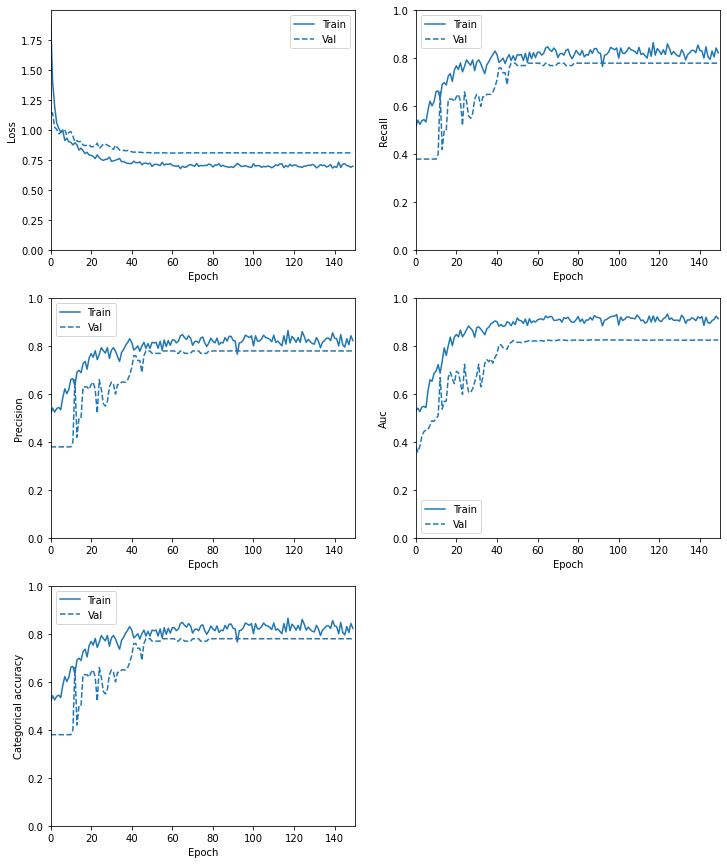

In [9]:
%%time

plot_training_history(history)

In [10]:
%%time

show_simple_metrics(model, test_seq)

loss: 0.7936940789222717
recall: 0.7799999713897705
precision: 0.7799999713897705
auc: 0.825499951839447
categorical_accuracy: 0.7799999713897705

Wall time: 23.8 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8333333333333334
recall: 0.8064516129032258
f1-score: 0.819672131147541
support: 62


CN
precision: 0.7
recall: 0.7368421052631579
f1-score: 0.717948717948718
support: 38


micro avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


macro avg
precision: 0.7666666666666666
recall: 0.7716468590831917
f1-score: 0.7688104245481295
support: 100


weighted avg
precision: 0.7826666666666666
recall: 0.78
f1-score: 0.7810172341319883
support: 100


samples avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


F1
micro: 0.78
macro: 0.7688104245481295


accuracy_score: 0.78
sensitivity_score: 0.8064516129032258
specificity_score: 0.7368421052631579


Wall time: 22.3 s


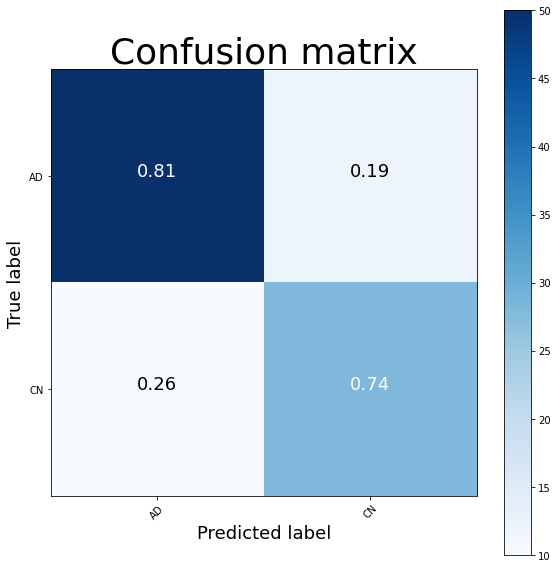

In [11]:
%%time

show_metrics(model, test_seq, class_names)